In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import random

This file containts the same calculations and graphing as project-code, but this time we are using 32 parameters (added nieces and nephews)

Constants

In [2]:
male_ego_parameters = ["mMM", "mMF", "mFM", "mFF", 
"mMyZ", "mMyB", "mM", "mMeZ", "mMeB", "mFyZ", "mFyB", "mF", "mFeZ", "mFeB",
"myZ", "myB", "meZ", "meB", 
 "mD", "mS", 
"myZD", "myZS", "myBD", "myBS", "meZD", "meZS", "meBD", "meBS",
 "mDD", "mDS", "mSD", "mSS"]
female_ego_parameters = ["fMM", "fMF", "fFM", "fFF", 
"fMyZ", "fMyB", "fM", "fMeZ", "fMeB", "fFyZ", "fFyB", "fF", "fFeZ", "fFeB",
"fyZ", "fyB", "feZ", "feB", 
 "fD", "fS", 
"fyZD", "fyZS", "fyBD", "fyBS", "feZD", "feZS", "feBD", "feBS",
 "fDD", "fDS", "fSD", "fSS"]

In [3]:
#language_families = ["Indo-European", "Sino-Tibetan", "Algic", "Pama-Nyungan", "Afro-Asiatic"]
# issue families: Uralic, 
language_families = ['Salishan', 'Austroasiatic', 'Sino-Tibetan', 'Afro-Asiatic', 'Indo-European', 'Pano-Tacanan', 
                       'Nuclear Trans New Guinea', 'Pama-Nyungan', 
                       'Tai-Kadai', 'Other', 'Arawakan', 'Austronesian', 'Algic', 'Cariban', 
                       'Nakh-Daghestanian', 'Turkic', 'Dravidian', 
                     'Uto-Aztecan', 'Atlantic-Congo', 'Tupian']
#language_families = ["Afro-Asiatic"]

Filter dataframe into parameters and kinterms and make dictionary

In [4]:
# makes the data frame of parameters, word for the selected parameters for the first source
def make_rows(data_frame, ego_parameters):
    all_rows = data_frame.loc[data_frame['parameter'].isin(ego_parameters)]
    rows = None
    if len(all_rows['source_bibtex'].value_counts()) <= 0:
        rows = all_rows
    else:
        most_frequent_source = all_rows['source_bibtex'].value_counts().idxmax()
        mask = all_rows['source_bibtex'] == most_frequent_source
        rows = all_rows.loc[mask]
    return rows

In [5]:
def make_lang_dict(rows):
    parameter_pairs = rows[["parameter", "word"]].values.tolist()
    lang_dict = {}
    for pair in parameter_pairs:
        if pair[0] not in lang_dict:
            lang_dict[pair[0]] = pair[1]
    return lang_dict

Calculate the complexity.

In [6]:
def complexity(female_dict, male_dict):
    female_kinwords = len(list(np.unique(list(female_dict.values()))))
    male_kinwords = len(list(np.unique(list(male_dict.values()))))
    complexity = (female_kinwords + male_kinwords) / 2
    return complexity

Calculate the informativeness (communicative cost).

In [7]:
# male_ego_parameters
# female_ego_parameters

# Need probabilities from English and German Corpus for all female and male
pi = [0.014451288, 0.010966314, 0.014451288, 0.010966314,
      0.003197676, 0.004767618, 0.291375328, 0.003197676, 0.004767618,
      0.003197676, 0.004767618, 0.295423085, 0.003197676, 0.004767618,
      0.026383051, 0.034053058, 0.026383051, 0.034053058, 
      0.088273482, 0.098266616, 
      0.000674385, 0.000787767, 0.000674385, 0.000787767, 0.000674385, 0.000787767, 0.000674385, 0.000787767, 
      0.0014217, 0.002206822, 0.0014217, 0.002206822]
female_pi = {}
male_pi = {}

for i, key in enumerate(female_ego_parameters):
    female_pi[key] = pi[i]
    
for i, key in enumerate(male_ego_parameters):
    male_pi[key] = pi[i]

In [8]:
# Helper Function:
def entropy(pi, sum_p):
    if sum_p == 0:
        return 0
    else:
        return pi * -math.log2(pi/sum_p)

def c_cost(dic, pi):
    # Calculate the additional cost c_i in bits for each individual
    total = 0
    for key, value in dic.items():
        pi_num = pi[key]
        same_keys = []
        for k, v in dic.items():
            if v == value:
                same_keys.append(k)
        pj = sum([pi[i] for i in same_keys])
        total += entropy(pi_num, pj)
    return total

In [9]:
def language_c_cost(female_dict, male_dict):
    return (c_cost(female_dict, female_pi)+ c_cost(male_dict, male_pi))/2

Here, we iterate through the selected language families

In [10]:
real_lang_complexities = []
real_lang_cc = []

for fam in language_families:
    path = "kinbank-master/kinbank/raw/" + fam
    dir_list = os.listdir(path)
    for lang in dir_list:
        #print("kinbank-master/kinbank/raw/" + fam + "/" + lang)
        lang_df = pd.read_csv("kinbank-master/kinbank/raw/" + fam + "/" + lang, low_memory=False)
        female_rows = make_rows(lang_df, female_ego_parameters)
        male_rows = make_rows(lang_df, male_ego_parameters)
        # check that there are at least 32 parameters
        if len(np.unique(female_rows['parameter'].values.tolist())) >= 32 or len(
            np.unique(male_rows['parameter'].values.tolist())) >= 32:
            female_dict = make_lang_dict(female_rows)
            male_dict = make_lang_dict(male_rows)
            real_lang_complexities.append(complexity(female_dict, male_dict))
            real_lang_cc.append(language_c_cost(female_dict, male_dict))
#         print("kinbank-master/kinbank/raw/" + fam + "/" + lang)
#         print("female:", len(female_rows))
#         print("male:", len(male_rows))
#         if len(female_rows) == 0:
#             print("this language has 0 parameters for female")
#         if len(male_rows) == 0:
#             print("this language has 0 parameters for male")
# print(len(real_lang_complexities), len(real_lang_cc))
# print("complexities:", real_lang_complexities)
# print("communicative costs:", real_lang_cc)

Here we make new possible language systems

In [11]:
# function to make a new permutation dictionary
def make_perm_dict(perm_kin_params):
    max_kinterms = random.randint(1, 32)
    perm_dict = {}
    for param in perm_kin_params:
        perm_dict[param] = random.randint(1, max_kinterms)
    return perm_dict
make_perm_dict(male_ego_parameters)

def make_perm_dict_subset(perm_kin_params):
    max_kinterms = random.randint(1, len(perm_kin_params))
    perm_dict = {}
    for param in perm_kin_params:
        perm_dict[param] = random.randint(1, max_kinterms)
    return perm_dict

In [12]:
perm_lang_complexities = []
perm_lang_cc = []

# do 200 permutations
for i in range(10000):
    female_perm_dict = make_perm_dict(female_ego_parameters)
    male_perm_dict = make_perm_dict(male_ego_parameters)
    perm_lang_complexities.append(complexity(female_perm_dict, male_perm_dict))
    perm_lang_cc.append(language_c_cost(female_perm_dict, male_perm_dict))
    
# print(len(perm_lang_cc), len(perm_lang_complexities))
# print("complexities:", perm_lang_complexities)
# print("communicative cost:", perm_lang_cc)

In [13]:
# notes

# some families might not care about other members, or there is just not enough data

Data Visualization

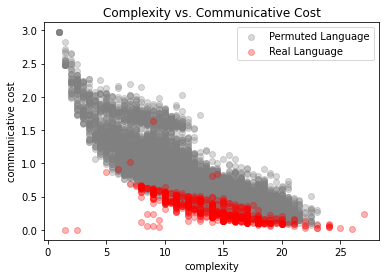

In [14]:
# Complexity vs Communicative cost for all selected langauge families


# Create a scatterplot
plt.scatter(perm_lang_complexities, perm_lang_cc, alpha = 0.3,  label='Permuted Language', color = "gray")
# Special Language

# Overlaying
plt.scatter(real_lang_complexities, real_lang_cc, alpha = 0.3, label='Real Language', color = "red")


# Add a title and axis labels
plt.title('Complexity vs. Communicative Cost')
plt.xlabel('complexity')
plt.ylabel('communicative cost')

# Add a legend
plt.legend()

# Show the plot
plt.show()


Optimality analyses for six subsets of the full family tree.

In [15]:
# Subsets

## grandparents
    
female_grandparents_parameters = ["fMM", "fMF", "fFM", "fFF"]
male_grandparents_parameters = ["mMM", "mMF", "mFM", "mFF"]

## parents

female_parents = ["fM", "fF"]
male_parents = ["mM", "mF"]

## childern

female_children =  ["fD", "fS"]
male_children =  ["mD", "mS"]

## grandchildren

female_grandchildren_parameters = ["fDD", "fDS", "fSD", "fSS"]
male_grandchildren_parameters = ["mDD", "mDS", "mSD", "mSS"]

## siblings

female_siblings =  ["fyZ", "fyB", "feZ", "feB"]
male_siblings =  ["myZ", "myB", "meZ", "meB"]

## mother+aunt

female_mother_aunt =  ["fMyZ","fM", "fMeZ", "fFyZ", "fFeZ"]
male_mother_aunt =  ["mMyZ","mM", "mMeZ", "mFyZ", "mFeZ"]

## father+uncle

female_father_uncle =  ["fMyB","fMeB", "fFyB", "fF", "fFeB"]
male_father_uncle =  ["mMyB","mMeB", "mFyB", "mF", "mFeB"]

In [16]:
# Helper Function:

def iteration_com_cc(real_lang_complexities, real_lang_cc, female_ego_parameters, male_ego_parameters):
    for fam in language_families:
        path = "kinbank-master/kinbank/raw/" + fam
        dir_list = os.listdir(path)
        for lang in dir_list:
            #print("kinbank-master/kinbank/raw/" + fam + "/" + lang)
            lang_df = pd.read_csv("kinbank-master/kinbank/raw/" + fam + "/" + lang, low_memory=False)
            female_rows = make_rows(lang_df, female_ego_parameters)
            male_rows = make_rows(lang_df, male_ego_parameters)
            # check that there are at least 32 parameters
            if len(np.unique(female_rows['parameter'].values.tolist())) >= len(female_ego_parameters) or len(
                np.unique(male_rows['parameter'].values.tolist())) >= len(female_ego_parameters):
                female_dict = make_lang_dict(female_rows)
                male_dict = make_lang_dict(male_rows)
                real_lang_complexities.append(complexity(female_dict, male_dict))
                real_lang_cc.append(language_c_cost(female_dict, male_dict))
                
def permutation_subset(perm_lang_complexities, perm_lang_cc, female_ego_parameters, male_ego_parameters):
    # do 1000 permutations
    for i in range(1000):
        female_perm_dict = make_perm_dict_subset(female_ego_parameters)
        male_perm_dict = make_perm_dict_subset(male_ego_parameters)
        perm_lang_complexities.append(complexity(female_perm_dict, male_perm_dict))
        perm_lang_cc.append(language_c_cost(female_perm_dict, male_perm_dict))

In [17]:
# real langauge

grandparents_complexities = []
grandparents_cc = []
g_perm_com = []
g_perm_cc = []


siblings_complexities = []
siblings_cc = []
si_perm_com = []
si_perm_cc = []

mother_aunt_complexities = []
mother_aunt_cc = []
ma_perm_com = []
ma_perm_cc = []

father_uncle_complexities = []
father_uncle_cc = []
fu_perm_com = []
fu_perm_cc = []

# real data
iteration_com_cc(grandparents_complexities, grandparents_cc,female_grandparents_parameters, male_grandparents_parameters )
iteration_com_cc(siblings_complexities,siblings_cc,female_siblings, male_siblings)
iteration_com_cc(mother_aunt_complexities,mother_aunt_cc,female_mother_aunt, male_mother_aunt)
iteration_com_cc(father_uncle_complexities,father_uncle_cc,female_father_uncle, male_father_uncle)


# permuted data
permutation_subset(g_perm_com, g_perm_cc,female_grandparents_parameters, male_grandparents_parameters )
permutation_subset(si_perm_com ,si_perm_cc,female_siblings, male_siblings)
permutation_subset(ma_perm_com,ma_perm_cc,female_mother_aunt, male_mother_aunt)
permutation_subset(fu_perm_com,fu_perm_cc,female_father_uncle, male_father_uncle)

In [18]:
# Create a 2D histogram of the data
def create_2D(x, y):
    hist, xedges, yedges = np.histogram2d(x, y, bins=7)
    xidx = np.clip(np.digitize(x, xedges), 0, hist.shape[0]-1)
    yidx = np.clip(np.digitize(y, yedges), 0, hist.shape[1]-1)
    return hist[xidx, yidx]

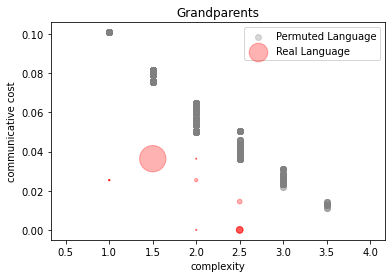

In [19]:
# Complexity vs Communicative cost for family member subsets

# Define the size of the dots based on the counts
sizes = create_2D(grandparents_complexities, grandparents_cc) * 1.2


# Create a scatterplot
plt.scatter(g_perm_com, g_perm_cc, alpha = 0.3,  label='Permuted Language', color = "gray")
# Overlaying
plt.scatter(grandparents_complexities, grandparents_cc, alpha = 0.3, label='Real Language', color = "red", s = sizes)



# Add a title and axis labels
plt.title('Grandparents')
plt.xlabel('complexity')
plt.ylabel('communicative cost')

# Add a legend
plt.legend()

# Show the plot
plt.show()

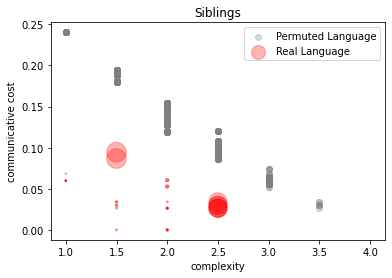

In [20]:
# Define the size of the dots based on the counts
sizes = create_2D(siblings_complexities, siblings_cc) * 1.2


# Create a scatterplot
plt.scatter(si_perm_com, si_perm_cc, alpha = 0.3,  label='Permuted Language', color = "gray")
# Overlaying
plt.scatter(siblings_complexities, siblings_cc, alpha = 0.3, label='Real Language', color = "red", s = sizes)



# Add a title and axis labels
plt.title('Siblings')
plt.xlabel('complexity')
plt.ylabel('communicative cost')

# Add a legend
plt.legend()

# Show the plot
plt.show()

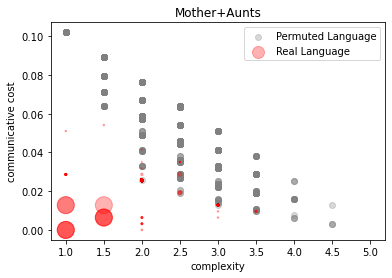

In [21]:
# Define the size of the dots based on the counts
sizes = create_2D(mother_aunt_complexities, mother_aunt_cc) * 1.2


# Create a scatterplot
plt.scatter(ma_perm_com, ma_perm_cc, alpha = 0.3,  label='Permuted Language', color = "gray")
# Overlaying
plt.scatter(mother_aunt_complexities, mother_aunt_cc, alpha = 0.3, label='Real Language', color = "red", s = sizes)



# Add a title and axis labels
plt.title('Mother+Aunts')
plt.xlabel('complexity')
plt.ylabel('communicative cost')

# Add a legend
plt.legend()

# Show the plot
plt.show()

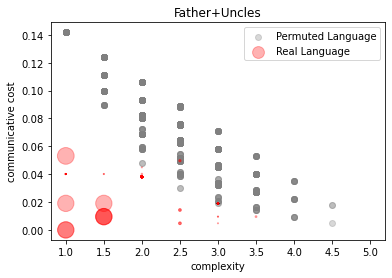

In [22]:
# Define the size of the dots based on the counts
sizes = create_2D(father_uncle_complexities, father_uncle_cc) * 1.2


# Create a scatterplot
plt.scatter(fu_perm_com, fu_perm_cc, alpha = 0.3,  label='Permuted Language', color = "gray")
# Overlaying
plt.scatter(father_uncle_complexities, father_uncle_cc, alpha = 0.3, label='Real Language', color = "red", s = sizes)



# Add a title and axis labels
plt.title('Father+Uncles')
plt.xlabel('complexity')
plt.ylabel('communicative cost')

# Add a legend
plt.legend()

# Show the plot
plt.show()